In [81]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals, print_function, division
import string
import random
from data_utils import *
from rnn import *
import torch
import codecs
from tqdm import tqdm
import string
import subprocess
import json
import matplotlib.pyplot as plt

#Set GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Load vocabulary files
input_lang = torch.load('data-bin/fra.data')
output_lang = torch.load('data-bin/eng.data')

#Create and empty RNN model
encoder = EncoderRNN(input_size=input_lang.n_words, device=device)
attn_decoder = AttnDecoderRNN(output_size=output_lang.n_words, device=device)

#Load the saved model weights into the RNN model
encoder.load_state_dict(torch.load('model/encoder'))
attn_decoder.load_state_dict(torch.load('model/decoder'))
encoder = encoder.to(device)
attn_decoder = attn_decoder.to(device)

#Return the decoder output given input sentence 
#Additionally, the previous predicted word and previous decoder state can also be given as input
def translate_single_word(encoder, decoder, sentence, decoder_input=None, decoder_hidden=None, max_length=MAX_LENGTH, device=device):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence, device)
        input_length = input_tensor.size()[0]
        
        encoder = encoder.to(device)
        decoder = decoder.to(device)
        
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        if decoder_input==None:
            decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        else:
            decoder_input = torch.tensor([[output_lang.word2index[decoder_input]]], device=device) 
        
        if decoder_hidden == None:        
            decoder_hidden = encoder_hidden
        
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        return decoder_output.data, decoder_hidden


# It reads hardcoded sentences as input, translates using the trained RNN and saves the outputs in example.txt file.
def translate_example():
	target_sentences = ["i can speak a bit of french .",
			"i ve bought some cheese and milk .",
			"boy where is your older brother ?",
			"i ve just started reading this book .",
			"she loves writing poems ."]

	source_sentences = ["je parle un peu francais .",
				"j ai achete du fromage et du lait .",
				"garcon ou est ton grand frere ?",
				"je viens justement de commencer ce livre .",
				"elle adore ecrire des poemes ."]

	target = codecs.open('example.txt','w',encoding='utf-8')

	beam_size = 1
	for i,source_sentence in enumerate(source_sentences):

		target_sentence = normalizeString(target_sentences[i])
		input_sentence = normalizeString(source_sentence)
		
		hypothesis = beam_search(encoder, attn_decoder, input_sentence, beam_size=beam_size)
		
		print("S-"+str(i)+": "+input_sentence)
		print("T-"+str(i)+": "+target_sentence)
		print("H-"+str(i)+": "+hypothesis)
		print()
		target.write(hypothesis+'\n')
	target.close()    


###################################################################################################################
###Part 1. Write the function below to read the data/test.fra file and write the translations in test_beam_1.out###
###################################################################################################################
def translate_test(optimal_beam):
    with open('data/test.fra', 'r', encoding='utf-8') as file:
        test_sentences = file.readlines()

    with codecs.open('test_beam_1.out', 'w', encoding='utf-8') as output_file:
        for sentence in tqdm(test_sentences):
            input_sentence = normalizeString(sentence.strip())
            translated_sentence = beam_search(encoder, attn_decoder, input_sentence, beam_size=optimal_beam)
            output_file.write(translated_sentence + '\n')

def translate_beam_size(beam_size):
    with open('data/valid.fra', 'r', encoding='utf-8') as file:
        valid_sentences = file.readlines()

    output_filename = f'output_beam_{beam_size}.out'
    with open(output_filename, 'w', encoding='utf-8') as output_file:
        for sentence in valid_sentences:
            input_sentence = normalizeString(sentence.strip())
            translated_sentence = beam_search(encoder, attn_decoder, input_sentence, beam_size=beam_size)
            output_file.write(translated_sentence + '\n')

#############################################################################################
###Part 2. Modify this function to use beam search to predict instead of greedy prediction###
#############################################################################################
def beam_search(encoder, decoder, input_sentence, beam_size=1, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, input_sentence, device)
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        
        for ei in range(input_tensor.size()[0]):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        beams = [(torch.tensor([[SOS_token]], device=device), encoder_hidden, [], 0)]

        for _ in range(max_length):
            new_beams = []
            for decoder_input, decoder_hidden, decoded_words, score in beams:
                if decoded_words and decoded_words[-1] == EOS_token:
                    new_beams.append((decoder_input, decoder_hidden, decoded_words, score))
                    continue

                decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
                topv, topi = decoder_output.data.topk(beam_size)

                for i in range(beam_size):
                    next_word_idx = topi[0][i].item()
                    next_word = output_lang.index2word[next_word_idx]
                    new_score = score + topv[0][i].item()
                    new_beam = (torch.tensor([[next_word_idx]], device=device), decoder_hidden, decoded_words + [next_word], new_score)
                    new_beams.append(new_beam)
            beams = sorted(new_beams, key=lambda x: x[3], reverse=True)[:beam_size]
        best_beam = sorted(beams, key=lambda x: x[3], reverse=True)[0]
        return ' '.join(best_beam[2])

In [70]:
for k in tqdm(range(1, 21)):
    translate_beam_size(k)

  0%|          | 0/20 [00:07<?, ?it/s]


100%|██████████| 20/20 [00:07<00:00,  2.66it/s]


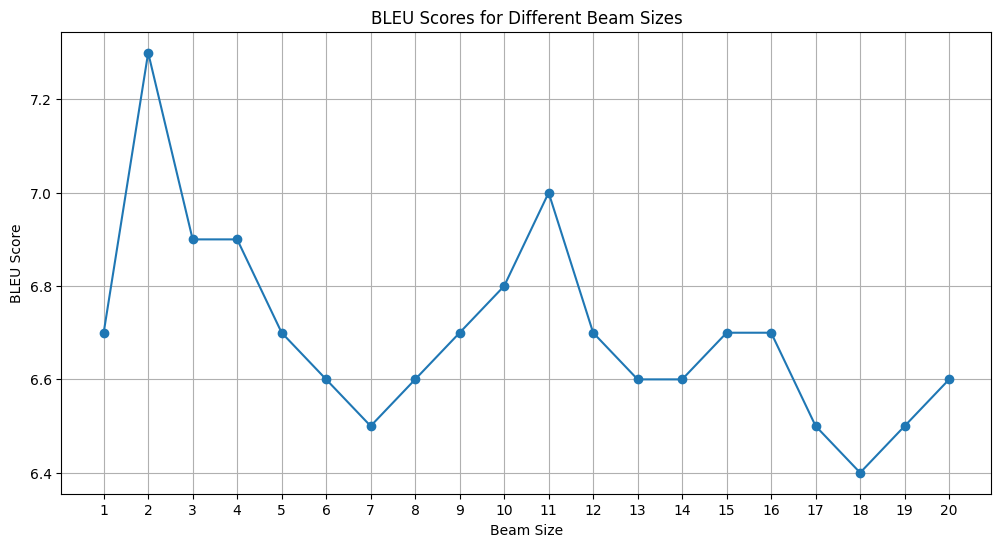

In [89]:
bleu_scores = []

for i in tqdm(range(1, 21)):
    output_file = f'output_beam_{i}.out'
    cmd = ['sacrebleu', 'data/valid.eng', '-i', output_file, '-m', 'bleu']
    result = subprocess.run(cmd, stdout=subprocess.PIPE, text=True)
    output = result.stdout.strip()
    bleu_result = json.loads(output)
    score = bleu_result["score"]
    bleu_scores.append(score)

beam_sizes = list(range(1, 21))
plt.figure(figsize=(12, 6))
plt.plot(beam_sizes, bleu_scores, marker='o')
plt.xlabel('Beam Size')
plt.ylabel('BLEU Score')
plt.title('BLEU Scores for Different Beam Sizes')
plt.xticks(beam_sizes)
plt.grid(True)
plt.savefig('bleu_scores_plot.png')
plt.show()

## The best K we got from part 3 is 2

In [92]:
translate_test(2)

100%|██████████| 997/997 [00:14<00:00, 71.13it/s]


In [93]:
!sacrebleu data/test.eng < test_beam_1.out

sacreBLEU: That's 100 lines that end in a tokenized period ('.')
sacreBLEU: It looks like you forgot to detokenize your test data, which may hurt your score.
sacreBLEU: If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
{
 "name": "BLEU",
 "score": 7.3,
 "signature": "nrefs:1|case:mixed|eff:no|tok:13a|smooth:exp|version:2.4.0",
 "verbose_score": "26.7/8.4/4.5/2.8 (BP = 1.000 ratio = 1.603 hyp_len = 9970 ref_len = 6218)",
 "nrefs": "1",
 "case": "mixed",
 "eff": "no",
 "tok": "13a",
 "smooth": "exp",
 "version": "2.4.0"
}
